In [33]:
from pathlib import Path
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

df = pd.read_csv(Path("/Users/arstanbek/Projects/fibrosis/BiTis/datasets") / "tissue_dataset.csv")

# Convert string representation of numpy arrays to numpy arrays:
df['Tissue Matrix'] = df['Tissue Matrix'].apply(
    lambda x: np.array(ast.literal_eval(x))
)
df['Tissue size'] = df['Tissue size'].apply(
    lambda x: ast.literal_eval(x)
)

# Filter the dataset to extract one specific texture that meets the criteria:
filtered_df = df[(df['Density'].between(0.3, 0.35)) &
                 (df['Elongation'] > 2.5)]

print(filtered_df.shape)
texture = filtered_df["Tissue Matrix"].iloc[1]

# 1 - healthy tissue, 2 - fibrosis
texture = np.where(texture == 0, 1, 2).astype(np.float32)

(4, 8)


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 9460.11it/s]


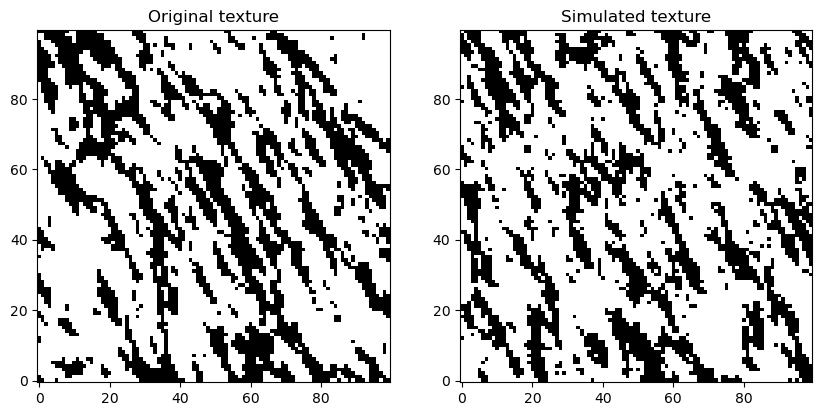

In [34]:
import bitis as bt

texture_ = texture[:, :].copy()
simulation_tex = np.zeros_like(texture_)

simulation = bt.AdaptiveSampling(simulation_tex,
                                 texture_,
                                 max_known_pixels=30,
                                 max_template_size=50,
                                 min_template_size=5,
                                 num_of_candidates=1,
                                 min_known_pixels=1,
                                 use_tf=False)

simulated_tex = simulation.run(max_iter=None)

simulated_smoothed = gaussian_filter(simulated_tex, sigma=1)
texture_smoothed_ = gaussian_filter(texture_, sigma=1)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].imshow(texture_, cmap='gray_r', origin='lower')
axs[0].set_title('Original texture')
axs[1].imshow(simulated_tex, cmap='gray_r', origin='lower')
axs[1].set_title('Simulated texture')
plt.show()

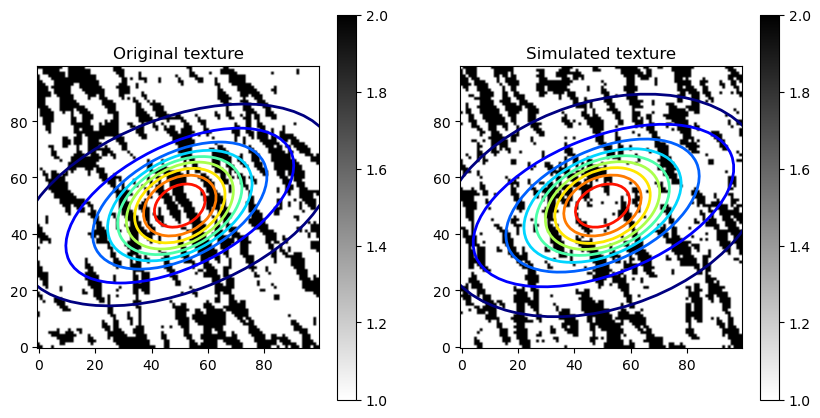

In [35]:
from scipy.ndimage import gaussian_filter
from skimage import measure
from matplotlib.patches import Ellipse


def calculate_power_spectrum(texture):
    texture_fft = np.fft.fftn(texture - texture.mean())
    texture_power = np.abs(texture_fft) ** 2
    texture_power = np.fft.fftshift(texture_power)
    return texture_power


def equivalent_ellipses(texture_power):
    ellipses = []
    for threshold in np.arange(0.1, 1.0, 0.1):
        texture_power = gaussian_filter(texture_power, sigma=4)
        sorted_idx = np.argsort(texture_power.ravel())
        cumsum = np.cumsum(texture_power.ravel()[sorted_idx])
        idx = sorted_idx[cumsum > cumsum[-1] * threshold]
        coords = np.unravel_index(idx, texture_power.shape)

        mask = np.zeros_like(texture_power, dtype=np.uint8)
        mask[tuple(coords)] = 1

        props = measure.regionprops(mask)
        short_axis = props[0].axis_minor_length
        long_axis = props[0].axis_major_length
        angle = props[0].orientation
        mean = props[0].centroid
        ellipses.append((mean, short_axis, long_axis, angle))
    return ellipses


tex_power = calculate_power_spectrum(texture)
sim_power = calculate_power_spectrum(simulated_tex)

sim_ellipses = equivalent_ellipses(sim_power)
tex_ellipses = equivalent_ellipses(tex_power)

cmap = plt.get_cmap('jet')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for ax, tex, ellipses in zip(axs, [texture, simulated_tex],
                             [tex_ellipses, sim_ellipses]):
    cax = ax.imshow(tex, cmap='gray_r', origin='lower')
    # draw ellipses
    for i, (mean, w, h, angle) in enumerate(ellipses):
        ellipse = Ellipse(mean[::-1], w, h, angle=np.degrees(np.pi - angle),
                        fill=False, lw=2, edgecolor=cmap(i / len(ellipses)))
        ax.add_patch(ellipse)

    fig.colorbar(cax, ax=ax)
axs[0].set_title('Original texture')
axs[1].set_title('Simulated texture')
plt.show()

In [36]:
# Shannon entropy

def shannon_entropy(tex_power):
    tex_power /= tex_power.sum()
    return -np.sum(tex_power * np.log(tex_power)) / np.log(tex_power.size)


tex_entropy = shannon_entropy(tex_power)
sim_entropy = shannon_entropy(sim_power)

print(f"Original texture entropy: {tex_entropy:.2f}")
print(f"Simulated texture entropy: {sim_entropy:.2f}")

Original texture entropy: 0.83
Simulated texture entropy: 0.84


In [38]:
# Moran's I
from scipy.signal import convolve

def morans_i(texture):
    # sum(sum(w_ij * x_i * x_j)) / sum(x_i^2)
    # w_ij - weight matrix
    # x_i - texture pixel value
    tex_mean = texture - texture.mean()
    kernel = np.array([[1/np.sqrt(8), 1/np.sqrt(5), 1/2, 1/np.sqrt(5), 1/np.sqrt(8)],
                       [1/np.sqrt(5), 1/np.sqrt(2), 1, 1/np.sqrt(2), 1/np.sqrt(5)],
                       [1/2, 1, 0, 1, 1/2],
                       [1/np.sqrt(5), 1/np.sqrt(2), 1, 1/np.sqrt(2), 1/np.sqrt(5)],
                       [1/np.sqrt(8), 1/np.sqrt(5), 1/2, 1/np.sqrt(5), 1/np.sqrt(8)]])
    
    morans_i = convolve(tex_mean, kernel, mode='same')
    morans_i = np.sum(tex_mean * morans_i) / np.sum(tex_mean ** 2)
    morans_i = morans_i * texture.size / kernel.sum()
    return morans_i


print(morans_i(texture))
print(morans_i(simulated_tex))

4190.889251296685
3847.0088784508525
